### Visualization: Passes
<h5>Notebook Brief:</h5>

In this notebook, I attempt to visualize and get insights out of passes data of the World Cup 2022. 

<h5>Workflow (Steps):</h5>

- Dembele's two footdness
- Pass network
- Where players receives (heatmap)
- Goalkicks Analysis (Clustering and hexbin plots)

Imports 

In [1]:
from statsbombpy import sb
import pandas as pd
import numpy as np

import seaborn as sn 
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from mplsoccer import Pitch, FontManager, VerticalPitch
from PIL import Image

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')
font_bold = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/'
                        'RobotoSlab%5Bwght%5D.ttf')
font_italic = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/roboto/'
                          'Roboto-Italic%5Bwdth,wght%5D.ttf')

In [2]:
df_comps=  sb.competitions()

# Get competition and season ids 
df_comps[(df_comps.competition_name== 'FIFA World Cup') & (df_comps.season_name== '2022')]

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
18,43,106,International,FIFA World Cup,male,False,True,2022,2023-02-07T02:23:23.053829,2023-02-06T13:54:57.267205,2023-02-06T13:54:57.267205,2023-02-07T02:23:23.053829


In [3]:
grouped_events = sb.competition_events(
    country="International",
    division= "FIFA World Cup",
    season="2022",
    split=True
)

In [4]:
df= grouped_events["passes"]
df.head(2)

,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,...,pass_cut_back,pass_outswinging,counterpress,pass_goal_assist,pass_through_ball,pass_no_touch,pass_deflected,pass_miscommunication,out,pass_straight
0,8511aa0e-af0f-45be-b405-1286bbe70571,5,1,00:00:00.292,0,0,Pass,2,Switzerland,From Kick Off,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ad0af88b-102f-4bc4-93a5-fac3e06ecce2,8,1,00:00:09.207,0,9,Pass,2,Switzerland,From Kick Off,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


1. Dembele's two footdness plot 

In [5]:
# Split location column into start_X and start_Y columns 
df[['start_X', 'start_Y']] = pd.DataFrame(df['location'].to_list(), index= df.index)
df[['end_X', 'end_Y']]= pd.DataFrame(df['pass_end_location'].to_list(), index= df.index)

# Filter passes
df= df.loc[df.play_pattern.isin(['Regular Play', 'From Counter', 'From Free Kick'])]
DF= df.loc[(df.player== 'Ousmane Dembélé') & 
                          (df.pass_body_part.isin(('Right Foot', 'Left Foot')))]

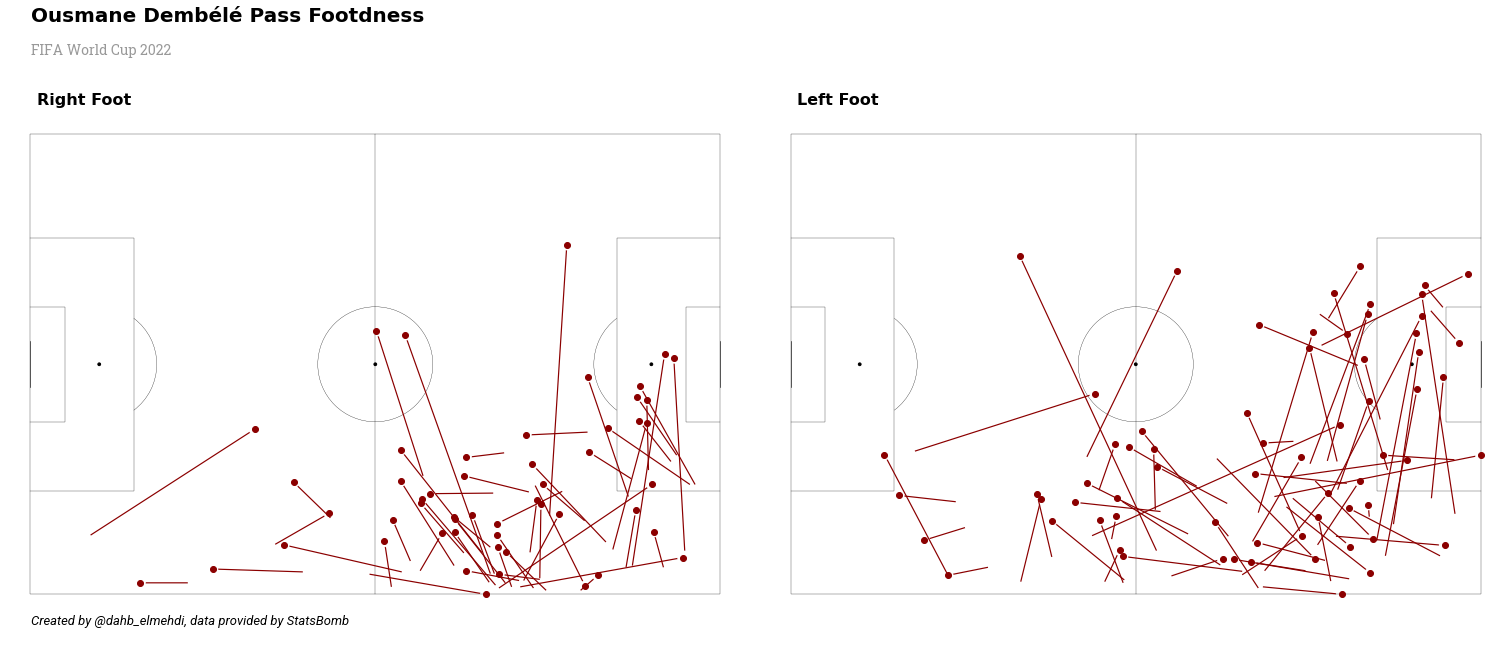

In [6]:
# Set pitches
pitch = Pitch(pitch_type= 'statsbomb',pad_bottom=0.5, goal_alpha=1,
                      pitch_color= 'white', line_color='black', linewidth=.3) 
fig, ax= pitch.grid(ncols= 2, grid_height= .75, space= .05, axis= False)
fig.set_facecolor("White")

# Plotting
X= list(DF.start_X)
Y= list(DF.start_Y)
end_X= list(DF.end_X)
end_Y= list(DF.end_Y)
foot= list(DF.pass_body_part)

for i in range(len(X)):
    if foot[i]=='Right Foot':
        ax['pitch'][0].scatter(end_X[i], end_Y[i],color="#8B0000")
        pitch.arrows(X[i], Y[i], end_X[i], end_Y[i], color = "#8B0000", width=1.2, headwidth= 0, ax=ax['pitch'][0])
    else:
        ax['pitch'][1].scatter(end_X[i], end_Y[i],color="#8B0000")
        pitch.arrows(X[i], Y[i], end_X[i], end_Y[i], color = "#8B0000", width=1.2, headwidth= 0, ax=ax['pitch'][1])

ax['pitch'][0].set_title(label="Right Foot", loc='left',x= .04, fontweight='bold', fontsize= 16)
ax['pitch'][1].set_title(label="Left Foot", loc='left',x= .04, fontweight='bold', fontsize= 16)

# To set titles in later plots
def set_titles(fig, title, subtitle, description):
    fig.text(0.04, .97, title, fontsize=20, fontweight= 'bold', color='black')
    fig.text(0.04, .92, subtitle, fontsize=14, color='black',fontproperties= font_bold.prop,alpha=.4)
    fig.text(0.04, .04, description, fontsize=13, color='black',fontproperties= font_italic.prop)

title_text= "Ousmane Dembélé Pass Footdness"
subtitle= "FIFA World Cup 2022"
Description= 'Created by @dahb_elmehdi, data provided by StatsBomb'
set_titles(fig, title_text, subtitle, Description)

# Save the graph
fig.savefig("../Plots/passes-1.png", dpi= 150, bbox_inches='tight')

2. Passing network

To create a pass network, we must first gather information about player positioning and amount of passes. These details can be summarized as follows:
- Average player locations 
- Number of passes between players
- Color and fifth line are determined by the number of connections and passes made by participants.

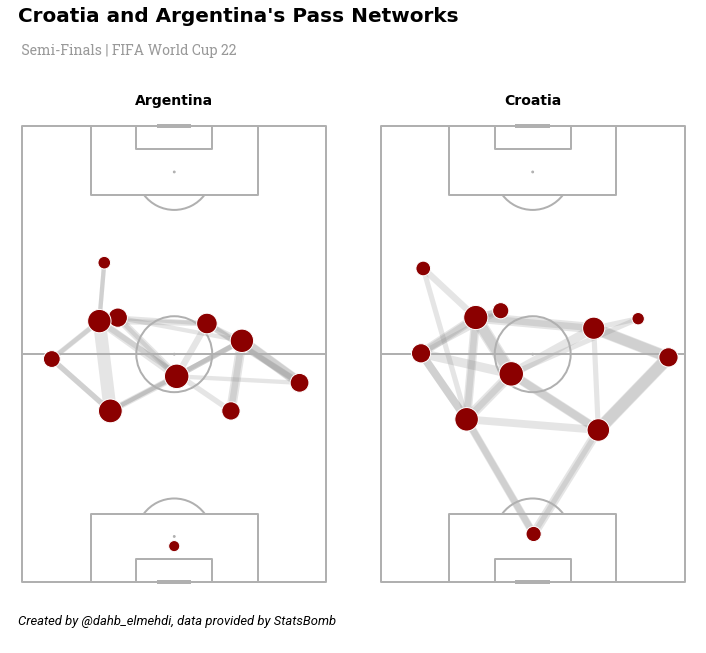

In [7]:
# First let's import events data of the World Cup final
msdf= sb.matches(competition_id=43, season_id=106)
final_id= int(msdf.loc[
    (msdf.competition_stage== 'Semi-finals') &
    ((msdf.home_team== 'Argentina') | (msdf.away_team== 'Argentina'))
               ].match_id.values)

events = sb.events(match_id=final_id)

pitch = VerticalPitch(half=False)
fig, ax= pitch.grid(ncols= 2, grid_height= .75, space= .05, axis= False)
fig.set_facecolor("White")    

for team in enumerate(events.team.unique()):   
    first_sub= events.loc[(events.type== 'Substitution') & (events.team== team[1])].minute.min()
    DF= events.loc[(~events.pass_outcome.isin(['Out', 'Incomplete', 'Unknown', 'Pass Offside'])) & (events.team== team[1] ) &
                  (events.type=='Pass') & (events.minute< first_sub)]

    DF[['start_X', 'start_Y']] = pd.DataFrame(DF['location'].to_list(), index= DF.index)
    DF[['end_X', 'end_Y']]= pd.DataFrame(DF['pass_end_location'].to_list(), index= DF.index)

    # Average locations 
    avg_locations= DF.groupby('player').agg({'start_X':['mean', 'count'], 'start_Y': 'mean'})
    #Rename columns
    avg_locations.columns= ['X','count', 'Y']

    # Numbers of passses btween players
    pass_between= DF.groupby(['player', 'pass_recipient']).id.count().reset_index()
    pass_between.rename({'id': 'number_of_passes'}, axis=1, inplace=True)

    # Merge the 2 dataframes to get average location starting and ending location of passes
    pass_between= pass_between.merge(avg_locations, on='player')
    pass_between= pass_between.merge(avg_locations, left_on='pass_recipient', right_index=True, suffixes=['', '_end'])
    pass_between= pass_between.loc[pass_between.number_of_passes> 3]
    pass_between.head()

    # Calculate the line width and marker sizes relative to the largest counts
    max_line_width= 13
    max_marker_size = 600
    pass_between['width']= pass_between.number_of_passes / pass_between.number_of_passes.max() * max_line_width
    avg_locations['marker_size']= (avg_locations['count'] / avg_locations['count'].max() * max_marker_size)

    # Set color to make the lines more transparent when fewer passes are made
    min_transparency= 0.3
    color= np.array(to_rgba('white'))
    color= np.tile(color, (len(pass_between), 1))
    c_transparency= pass_between.number_of_passes / pass_between.number_of_passes.max()
    c_transparency= (c_transparency * (1 - min_transparency)) + min_transparency
    color[:, 3]= c_transparency

    pass_between= pass_between.loc[pass_between.number_of_passes> 2]
    
    # Plotting
    pitch.lines(pass_between.X, pass_between.Y,
                            pass_between.X_end, pass_between.Y_end, lw=pass_between.width,
                            color='Grey', zorder=.1, ax=ax['pitch'][team[0]], alpha= .2)
    pitch.scatter(avg_locations.X, avg_locations.Y, s= avg_locations.marker_size, 
                               color='#8B0000', linewidth=1,edgecolor= 'white',alpha=1, ax=ax['pitch'][team[0]])
    # Set titles
    ax['pitch'][team[0]].set_title(label='{}'.format(team[1]), loc='center', fontweight='bold', fontsize= 14)

# set titles
title= "Croatia and Argentina's Pass Networks"
subtitle= " Semi-Finals | FIFA World Cup 22"
set_titles(fig, title, subtitle, Description)

# Save graph
fig.savefig("../Plots/passes-2.png", dpi= 150, bbox_inches='tight')

3. A heatmap displaying where African national teams strikers received the ball.



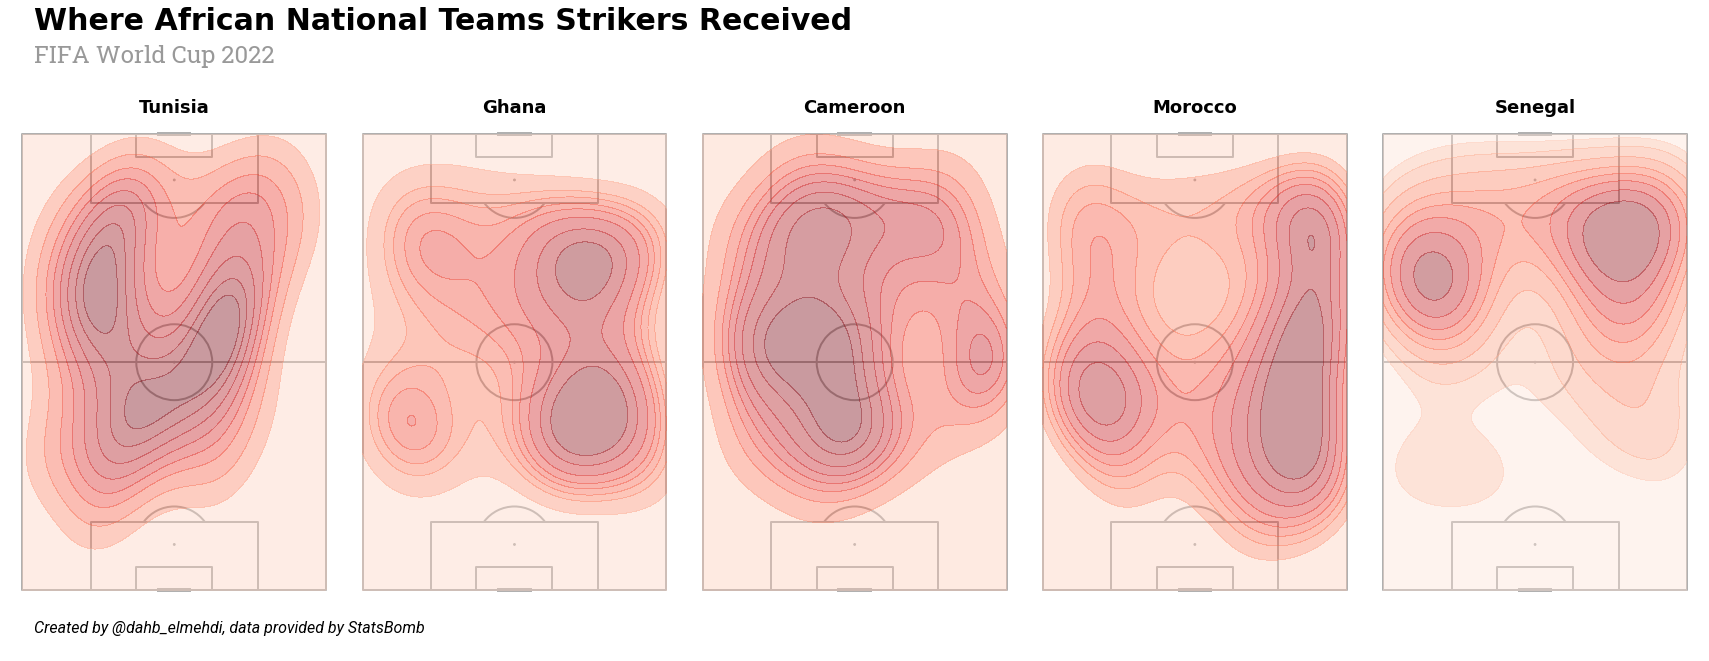

In [8]:
# African teams and strikers positions
african_teams= ['Tunisia', 'Ghana', 'Cameroon','Morocco', 'Senegal']
ST_positions= ['Center Forward', 'Left Wing', 'Right Wing', 'Left Center Forward', 'Right Center Forward']

# Filter data
df= df.loc[(~df.pass_outcome.isin(['Out', 'Incomplete', 'Unknown', 'Pass Offside'])) &
                         (df.team.isin(african_teams)) & (df.position.isin(ST_positions))]

# Set up pitches 
pitch = VerticalPitch(half=False)
fig, ax= pitch.grid(ncols= 5, grid_height= .75, space= .05, axis= False)
fig.set_facecolor("White") 

# Plotting 
import seaborn as sns
cmap = sns.cubehelix_palette(start=15, light=1, as_cmap=True)
for team in enumerate(african_teams):
    X= df.loc[df.team== team[1]].end_X.to_list()
    Y= df.loc[df.team== team[1]].end_Y.to_list()
    kde = pitch.kdeplot(X, Y, ax=ax['pitch'][team[0]], fill=True, shade_lowest=True, cmap="Reds", color="#8B0000", alpha=.4)
    ax['pitch'][team[0]].set_title(label='{}'.format(team[1]), loc='center', fontweight='bold', fontsize= 18)

# Set titles
title= "Where African National Teams Strikers Received"
subtitle= "FIFA World Cup 2022"
fig.text(0.04, .97, title, fontsize=30, fontweight= 'bold', color='black')
fig.text(0.04, .92, subtitle, fontsize=24, color='black',fontproperties= font_bold.prop,alpha=.4)
fig.text(0.04, .04, Description, fontsize=16, color='black',fontproperties= font_italic.prop)

# Save graph
fig.savefig("../Plots/passes-3.png", dpi= 150, bbox_inches='tight')

Goalkicks Analysis [ Zones Targeted ]. 
We will use the hexbin plot to determine where Morocco's goalkeeper Bouno has played his goalkicks.

In [9]:
# Filter goalkicks
df= grouped_events["passes"]
df= df.loc[df.pass_type== "Goal Kick"]
df.groupby(['player_id','player']).id.count().reset_index().sort_values(by= 'id', ascending=False)

,player_id,player,id
32,6785,Yassine Bounou,58
3,3099,Hugo Lloris,56
43,16531,Dominik Livaković,50
37,8326,Andries Noppert,40
27,5669,Wojciech Szczęsny,38
...,...,...,...
17,5228,Seyed Majid Hosseini,1
12,4353,Aymeric Laporte,1
6,3300,Maya Yoshida,1
2,3090,Nicolás Hernán Otamendi,1


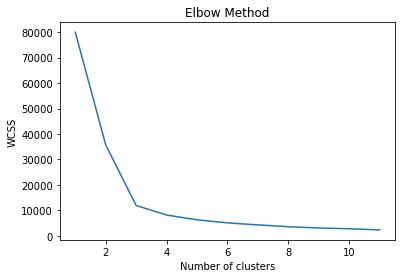

In [10]:
DF= df.loc[df.player== 'Yassine Bounou']
data= DF[list(DF.columns[-4:])].values

# Whithin clusters sum of squares
wcss= []

# Determine the best values of K using the elbow method
for k in range(1,12):
    kmeans= KMeans( n_clusters= k, init= 'k-means++', max_iter= 100, n_init= 10, random_state= 0)
    pred_y= kmeans.fit(data)
    wcss.append(kmeans.inertia_)

# Plot the correlation between Ks and wcss
plt.plot(range(1, 12), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# It looks like 3 is a great K 

In [11]:
# Fit the K-means model with the determined value of K
k = 3
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(data)

# add the pred_y as labels to the goalkicks
DF['label']= pred_y
means= DF.groupby(['label']).agg({'start_X': 'mean', 'start_Y': 'mean', 'end_X': 'mean', 'end_Y': 'mean'}).reset_index()

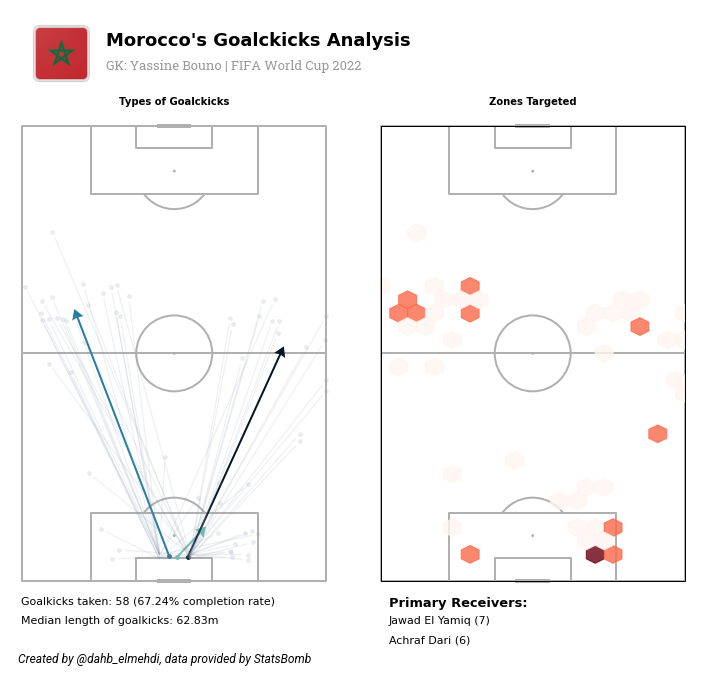

In [12]:
# Plotting
# Types of goalkciks (Clusters and Goalkicks)
pitch = VerticalPitch(half=False)
fig, ax= pitch.grid(ncols= 2, grid_height= .75, space= .05, axis= False)
fig.set_facecolor("White") 
color_map= {0: '#247ba0', 1: '#70c1b3', 2: '#011627'}

for label, sx, sy, ex, ey in means.values:
    ax['pitch'][0].scatter(sy, sx, color= color_map[label], s=14)
    pitch.arrows(sx, sy, ex, ey, color = color_map[label], width=2, headwidth= 6, ax=ax['pitch'][0])

ax['pitch'][0].scatter(DF.end_Y, DF.end_X, color = '#8d99ae', alpha= .15, s=14)
pitch.arrows(DF.start_X, DF.start_Y, DF.end_X, DF.end_Y, color = '#8d99ae',
             width=1.2, headwidth= 0, alpha=.15, ax=ax['pitch'][0])

gks_taken= len(DF)
completion_rate= (len(DF.loc[~DF.pass_outcome.isin(['Incomplete', 'Out', 'Unknown'])])/ len(DF))*100
distance =  np.sqrt((DF.start_X - DF.end_X)**2 + (DF.start_Y - DF.end_Y)**2)
median_length= distance.median()
ax['pitch'][0].text(x=0.04, y=0, s='Goalkicks taken: {} ({}% completion rate)'.format(gks_taken,round(completion_rate,2)),
                    fontsize=11, ha='left', va='top', transform=ax['pitch'][0].transAxes)
ax['pitch'][0].text(x=0.04, y=-.04, s='Median length of goalkicks: {}m'.format(round(median_length,2)), fontsize=11,
                ha='left', va='top', transform=ax['pitch'][0].transAxes)


# Zones Targeted
pitch.hexbin(x= DF.end_X, y= DF.end_Y, cmap= 'Reds', alpha= .8, ax= ax['pitch'][1])

ax['pitch'][1].text(x=0.07, y=0, s='Primary Receivers:', fontsize=13,
                    ha='left', va='top',fontweight='bold', transform=ax['pitch'][1].transAxes)
receivers= DF.groupby(['pass_recipient']).id.count().sort_values(ascending=False).reset_index()

y = -0.04
for name, n in (receivers.values[0:2]):
    ax['pitch'][1].text(x=0.07, y=y, s='{} ({})'.format(name,n), fontsize=11,
                        ha='left', va='top', transform=ax['pitch'][1].transAxes)
    y -= 0.04

# Set titles
title= "Morocco's Goalckicks Analysis"
subtitle= "GK: Yassine Bouno | FIFA World Cup 2022"
fig.text(0.16, .932, title, fontsize=18, fontweight= 'bold', color='black')
fig.text(0.16, .895, subtitle, fontsize=13, color='black',fontproperties= font_bold.prop,alpha=.4)
fig.text(0.04, -0.02, Description, fontsize=12, color='black',fontproperties= font_italic.prop)
ax['pitch'][0].set_title(label="Types of Goalckicks", loc='center', fontweight='bold', fontsize= 10)
ax['pitch'][1].set_title(label="Zones Targeted", loc='center', fontweight='bold', fontsize= 10)

# Add pictures
img_dir= "C:/Users/pc/Desktop/Morocco.png"    
ax= fig.add_axes([0, .87, 0.2, 0.1])
ax.axis("off")
img = Image.open(img_dir)
ax.imshow(img)

# Save pictures
fig.savefig("../Plots/passes-4.png", dpi= 150, bbox_inches='tight')